Final Project 2


* Student name: Reuben Hough
* Student pace: full time
* Scheduled project review date/time: 5/15/20
* Instructor name: Amber Yandow
* Blog post URL:


## Importing libraries

In [1]:
import sqlite3
import pandas as pd
from pandas.plotting import scatter_matrix
import pickle
import numpy as np
import matplotlib.pyplot
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
from glob import glob
import os
import seaborn as sns
import warnings
from scipy import stats
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder, Normalizer, MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, KFold, train_test_split, cross_validate
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, confusion_matrix, make_scorer, auc, accuracy_score, roc_curve
from sklearn.svm import LinearSVC, SVR
from itertools import combinations
%matplotlib inline

## Opening and reading data

In [2]:
df = pd.read_csv('kc_house_data.csv')
df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,...,11,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,7,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
7,2008000270,1/15/2015,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,...,7,1060,0.0,1963,0.0,98198,47.4095,-122.315,1650,9711
8,2414600126,4/15/2015,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,...,7,1050,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113
9,3793500160,3/12/2015,323000.0,3,2.50,1890,6560,2.0,0.0,0.0,...,7,1890,0.0,2003,0.0,98038,47.3684,-122.031,2390,7570


# Data Observation and Editing

There are clearly null values in the data that need to be dealt with before any kind of assesment is done, but first I will find out what they represent.

Null values exist in the "waterfront", "yr_renovated" and "view" categories, with "?" appearing in the data for "sq_basement"

In [3]:
print(df['waterfront'].value_counts(dropna=False))

0.0    19075
NaN     2376
1.0      146
Name: waterfront, dtype: int64


Waterfront refers to whether the property is found on the waterfront "1" or not, "0". With the vast majority of properties not on the waterfront, I believe it is warranted to replace null values with zero.

In [4]:
print(df['yr_renovated'].value_counts(dropna=False))

0.0       17011
NaN        3842
2014.0       73
2003.0       31
2013.0       31
          ...  
1944.0        1
1948.0        1
1976.0        1
1934.0        1
1953.0        1
Name: yr_renovated, Length: 71, dtype: int64


It would be inappropriate to replace the null values in the year renovated category with any value other than zero. Since again the vast majority of houses have not been renovated (Indicated by zero), I beleive it would be appropriate to replace null values with zero.

## Dealing with null values

In [5]:
# Null values in the waterfront and yr_renovated columns are replaced with zero as stated
df.waterfront.replace(np.NaN, 0.0, inplace=True)
df.yr_renovated.replace(np.NaN, 0.0, inplace=True)

In [6]:
# yr_renovated is turned into integer value
df.yr_renovated = df.yr_renovated.apply(lambda x: int(x))

I've found conflicting data on what "view" represents. It may be the number of times a house has been viewed, or an assessment of the view from the house. Either way, I will not be using this because both are somewhat arbitrary, so it will be dropped.

In [7]:
df.drop(['view'], axis=1, inplace=True)

## Replacing basement values

There are question marks in the data; thankfully it can all be replaced by subtracting the "above" square footage from total so there is no guessing involved.


In [8]:
df.sqft_basement = (df.sqft_living - df.sqft_above)

## Editing the date

In [9]:
# Making the Sale Date more useable
df['Year'] = df['date'].map(lambda x: '{}'.format(x[-4:].replace('/', '')))
df['Month'] = df['date'].map(lambda x: '{}'.format(x[:2].replace('/', '')))
df['Day'] = df['date'].map(lambda x: '{}'.format(x[-7:-5].replace('/', '')))
df['Day'] = df['Day'].map(lambda x: int(x))
df['Month'] = df['Month'].map(lambda x: int(x))
df['Year'] = df['Year'].map(lambda x: int(x))

In [10]:
# Making a function that turns the new date columns into a julian date
def julian(a,b,c):
    w=[]
    for x,y,z in zip(a,b,c):
         w.append(pd.Timestamp(year = x,  month = y, day = z).to_julian_date())
    return w

In [11]:
# Turning the date into a Julian date to make it more useable
df['Julian'] = julian(df['Year'], df['Month'], df['Day'])
df.sort_values(by='Julian')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Year,Month,Day,Julian
7316,2202500290,5/2/2014,435000.0,4,1.00,1450,8800,1.0,0.0,4,...,0,98006,47.5746,-122.135,1260,8942,2014,5,2,2456779.5
20586,7853361370,5/2/2014,555000.0,4,2.50,3310,6500,2.0,0.0,3,...,0,98065,47.5150,-121.870,2380,5000,2014,5,2,2456779.5
1040,7197300105,5/2/2014,550000.0,4,2.50,1940,10500,1.0,0.0,4,...,0,98052,47.6830,-122.114,2200,10500,2014,5,2,2456779.5
20543,3438501320,5/2/2014,295000.0,2,2.50,1630,1368,2.0,0.0,3,...,0,98106,47.5489,-122.363,1590,2306,2014,5,2,2456779.5
9587,472000620,5/2/2014,790000.0,3,2.50,2600,4750,1.0,0.0,4,...,0,98117,47.6833,-122.400,2380,4750,2014,5,2,2456779.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19381,8149600265,5/14/2015,725000.0,4,1.75,1980,5850,1.0,0.0,4,...,0,98116,47.5607,-122.391,1810,5850,2015,5,14,2457156.5
12623,4166600610,5/14/2015,335000.0,3,2.00,1410,44866,1.0,0.0,4,...,0,98023,47.3273,-122.370,2950,29152,2015,5,14,2457156.5
5632,7923600250,5/15/2015,450000.0,5,2.00,1870,7344,1.5,0.0,3,...,0,98007,47.5951,-122.144,1870,7650,2015,5,15,2457157.5
13040,5101400871,5/24/2015,445500.0,2,1.75,1390,6670,1.0,0.0,3,...,0,98115,47.6914,-122.308,920,6380,2015,5,24,2457166.5


Looking at the data for any obvious errors

In [12]:
print(df.describe())
print(df.info())

                 id         price      bedrooms     bathrooms   sqft_living  \
count  2.159700e+04  2.159700e+04  21597.000000  21597.000000  21597.000000   
mean   4.580474e+09  5.402966e+05      3.373200      2.115826   2080.321850   
std    2.876736e+09  3.673681e+05      0.926299      0.768984    918.106125   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123049e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront     condition         grade  \
count  2.159700e+04  21597.000000  21597.000000  21597.000000  21597.000000   
mean   1.509941e+04      1.494096      0.006760      3.409825      7.657915   
std    4.141264e+04      0.539683      0.081944    

33 bedrooms is almost certainly an error based on the square footage; it's probably meant to be 3, but I'm uncertain so it will be dropped

In [13]:
df = df.drop([15856])

## Checking for duplicate entries

In [14]:
# There are none
df.duplicated(keep=False).sum()

0

# Creating Data

## Making a new catergory "Seattle" That contains all zip codes within the greater Seattle area

In [15]:
# list found on seattlearea.com/zip-codes/
seattle = [98003, 98005, 98033, 98037, 98040, 98052, 98055, 98101, 98101, 98102,
            98103, 98103, 98103, 98104, 98104, 98105, 98105, 98107, 98109,
            98109, 98110, 98110, 98116, 98116, 98118, 98121, 98125, 98144, 98199]

In [16]:
# Creating category with a 1 if in Seattle and 0 if not
df['Seattle'] = df['zipcode'].apply(lambda x: 1 if x in seattle else 0)

## Binning Month by Season

In [17]:
# Puts december next to other winter months
forbin = df['Month'].replace(12,0)

In [18]:
monthbins = [0,3,6,9,11]
seasonlabels = ['Winter', 'Spring', 'Summer', 'Autumn']
binmonth = pd.cut(forbin, monthbins, labels = seasonlabels, include_lowest = True).cat.as_unordered()

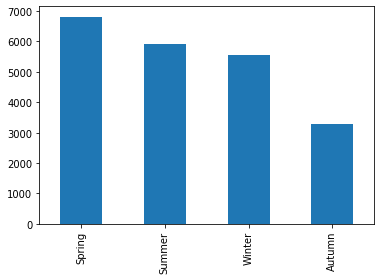

In [19]:
binmonth.value_counts().plot(kind='bar')

In [20]:
df['season'] = binmonth

In [21]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,...,lat,long,sqft_living15,sqft_lot15,Year,Month,Day,Julian,Seattle,season
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,3,...,47.5112,-122.257,1340,5650,2014,10,13,2456943.5,0,Autumn
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,3,...,47.7210,-122.319,1690,7639,2014,12,9,2457000.5,1,Winter
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,3,...,47.7379,-122.233,2720,8062,2015,2,25,2457078.5,0,Winter
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,5,...,47.5208,-122.393,1360,5000,2014,12,9,2457000.5,0,Winter
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,3,...,47.6168,-122.045,1800,7503,2015,2,18,2457071.5,0,Winter


Creating "basement" as a category for houses with a basement

In [22]:
df['basement'] = df['sqft_basement'].astype(bool).astype(int)

## Creating Dummy variables for categoricals

The catergorical variables that are not ordinal appear to be condition, grade, zipcode, basement, season, and waterfront

In [23]:
categoricals = ['condition', 'grade','zipcode','basement','season','waterfront']

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 27 columns):
id               21596 non-null int64
date             21596 non-null object
price            21596 non-null float64
bedrooms         21596 non-null int64
bathrooms        21596 non-null float64
sqft_living      21596 non-null int64
sqft_lot         21596 non-null int64
floors           21596 non-null float64
waterfront       21596 non-null float64
condition        21596 non-null int64
grade            21596 non-null int64
sqft_above       21596 non-null int64
sqft_basement    21596 non-null int64
yr_built         21596 non-null int64
yr_renovated     21596 non-null int64
zipcode          21596 non-null int64
lat              21596 non-null float64
long             21596 non-null float64
sqft_living15    21596 non-null int64
sqft_lot15       21596 non-null int64
Year             21596 non-null int64
Month            21596 non-null int64
Day              21596 non-null int64
Juli

In [33]:
for categorical in categoricals:
    pd.get_dummies(df[categorical], prefix = categorical, drop_first=True)
    df.drop(categorical, axis=1)
    df_preprocessed = pd.concat([df.drop(categorical, axis=1), dummies], axis=1)
df_preprocessed.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,...,season,basement,condition,grade,zipcode,basement,waterfront,season_Spring,season_Summer,season_Autumn
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,3,7,...,Autumn,0,3,7,98178,0,0.0,0,0,1
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,3,7,...,Winter,1,3,7,98125,1,0.0,0,0,0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,3,6,...,Winter,0,3,6,98028,0,0.0,0,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,5,7,...,Winter,1,5,7,98136,1,0.0,0,0,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,3,8,...,Winter,0,3,8,98074,0,0.0,0,0,0


In [36]:
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 34 columns):
id               21596 non-null int64
date             21596 non-null object
price            21596 non-null float64
bedrooms         21596 non-null int64
bathrooms        21596 non-null float64
sqft_living      21596 non-null int64
sqft_lot         21596 non-null int64
floors           21596 non-null float64
condition        21596 non-null int64
grade            21596 non-null int64
sqft_above       21596 non-null int64
sqft_basement    21596 non-null int64
yr_built         21596 non-null int64
yr_renovated     21596 non-null int64
zipcode          21596 non-null int64
lat              21596 non-null float64
long             21596 non-null float64
sqft_living15    21596 non-null int64
sqft_lot15       21596 non-null int64
Year             21596 non-null int64
Month            21596 non-null int64
Day              21596 non-null int64
Julian           21596 non-null float64
Seat

# Checking for Correlations in the Data to Eliminate Multicollinearity

These are subplots comparing price to several different factors

In [ ]:
variables = ['floors', 'bedrooms', 'bathrooms', 'condition', 'grade', 'Month']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,20))

for column, ax in zip(variables, axes.flatten()):
    (df.groupby(column).mean()['price'].sort_values().plot.bar(ax=ax))                
    
    ax.set_title(column)
    
fig.tight_layout()

Log transforming the price may the data easier to work with

In [ ]:
df['logprice'] = np.log(df['price'])
df[['price', 'logprice']].hist(figsize=(12,5),bins=30);

In [ ]:
variables = ['floors', 'bedrooms', 'bathrooms', 'condition', 'grade', 'Month']
for column, ax in zip(variables, axes.flatten()):
    (df.groupby(column).mean()['logprice'].sort_values().plot.bar(ax=ax))                
    
    ax.set_title(column)
    
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df[variables].corr(), cmap='coolwarm', annot=True, linewidths=.5, ax=ax);

In [ ]:
pd.plotting.scatter_matrix(df[variables], figsize=(10,12));

Several things are already noticable. There is minor correlation between bathrooms, grade, and bedrooms, which is expected. Living in the Seattle area, having a basement, and having more floors are good indicators of price.

Also sqft_above seems to have strong correlation with multiple columns so it should be eliminated.

In [ ]:
df.drop(['sqft_above'], axis=1, inplace=True)

In [ ]:
df.head()

## Binning month by season

In [ ]:
# Puts december next to other winter months
forbin = df['Month'].replace(12,0)

In [ ]:
monthbins = [0,3,6,9,11]
seasonlabels = ['Winter', 'Spring', 'Summer', 'Fall']
binmonth = pd.cut(forbin, monthbins, labels = seasonlabels, include_lowest = True).cat.as_unordered()

In [ ]:
binmonth.value_counts().plot(kind='bar')

Spring clearly has the most houses purchased, and fall is a very unpopular time to buy a house

## Checking for and removing outliers

Outliers will skew the data, so getting rid of a few outliers should help in that regard

In [ ]:
df.loc[df['sqft_lot15']>500000]

In [ ]:
df.loc[df['price']>6000000]

In [ ]:
df.loc[df['sqft_lot']>1000000]

In [ ]:
df.drop(index=[9509,13177,20010,3846,7105,9059,1687,7489,7610,16940], inplace=True)

## Creating a function to examine a histogram and Q-Q plot

In [ ]:
def diagnostic_plot(df, var):
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[var].hist(bins=30)
    plt.title(var)
    plt.subplot(1, 2, 2)
    stats.probplot(df[var], dist="norm", plot=plt)
    plt.title(var)
    plt.tight_layout()
    plt.show()

## Plotting Columns

In [ ]:
for col in df[variables]:
    diagnostic_plot(df,col)

# Using Linear Regression to Predict Prices

## Dropping columns that are no longer useful

In [ ]:
df.drop(['id', 'date'], axis=1, inplace=True)

## Train test split

The train test split is used to validate our regression model

In [ ]:
X = df.drop(['logprice'], axis=1)
y = df['logprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
x_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model_fit = sm.OLS(y_train, x_train).fit()
results_df = pd.concat([x_train, y_train], axis=1)
model_fit.summary()

## Looking for multicollinearity with zipcodes

In [ ]:
noprice = df.drop(['price', 'logprice'], axis = 1)

plt.figure(1, figsize=(20,20))
        
def multi_scatter_plot(x):
    sns.scatterplot(x, y="logprice", data=df) #iterating over dataframe minus price columns, adding subplots

for index, col in enumerate(noprice.columns, start=1):
    #adds subplot, using index to increment position of new subplot in a 5 column structure
    plt.subplot(11, 10,index) #call function to create plot

    multi_scatter_plot(col)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(olddf.corr(), cmap='coolwarm', annot=True, linewidths=.5, ax=ax);

## Performing Regression Diagnostics

In [ ]:
outcome = 'price'
predictors = '+'.join(variables)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

In [ ]:
outcome = 'logprice'
predictors = '+'.join(variables)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()